<div align="center"> <h2> Nhóm 17 - Lớp IS403.P23 - BÁO CÁO ĐỒ ÁN PHÂN TÍCH DỮ LIỆU KINH DOANH <h2> </div>
<div align="center">

<table>
  <thead>
    <tr>
      <th><div align="center">Họ và tên</div></th>
      <th><div align="center">MSSV</div></th>
    </tr>
  </thead>
  <tbody>
    <tr><td>🌱 Trần Vũ Bão</td><td>22520124</td></tr>
    <tr><td>🌱 Phan Thành Công</td><td>22520170</td></tr>
    <tr><td>🌱 Phan Thị Thủy Hiền</td><td>22520423</td></tr>
    <tr><td>🌱 Nguyễn Đỗ Đức Minh</td><td>22520872</td></tr>
  </tbody>
</table>
</div>

# Dự báo giá Bitcoin sử dụng mô hình Transformer

Triển khai hệ thống dự báo giá Bitcoin sử dụng mạng nơ-ron Transformer. Mô hình sử dụng dữ liệu giá Bitcoin lịch sử cùng
chỉ báo kỹ thuật RSI (Relative Strength Index) để dự đoán Close Price tương lai.

Mô hình Transformer:
- **Time2Vector Embedding**: Bổ sung đặc trưng tuần hoàn và tuyến tính cho chuỗi thời gian
- **Transformer Encoder-Decoder**: Nắm bắt các quan hệ dài hạn trong chuỗi
- **Multi-head Attention**: Cho phép mô hình tập trung vào các khía cạnh khác nhau của chuỗi đầu vào


## 1. Cài đặt môi trường & Đọc dữ liệu

In [35]:
!pip install pandas numpy torch torchsummary matplotlib seaborn scikit-learn
!pip install finta optuna plotly

In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from finta import TA
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Thiết lập seed ngẫu nhiên để tái tạo kết quả
torch.manual_seed(42)
np.random.seed(42)

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [37]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/btc_usd_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Đọc dữ liệu Bitcoin
data = pd.read_csv(file_path)

print("Kích thước dữ liệu:", data.shape)
print("\nTên các cột:")
print(data.columns.tolist())
print("\nMột vài dòng đầu:")
data.tail()

Kích thước dữ liệu: (2676, 7)

Tên các cột:
['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

Một vài dòng đầu:


,Date,Adj Close,Close,High,Low,Open,Volume
2671,2025-04-25,94720.500000,94720.500000,95768.390625,92898.593750,93954.250000,40915232364
2672,2025-04-26,94646.929688,94646.929688,95251.359375,93927.250000,94714.648438,17612825123
2673,2025-04-27,93754.843750,93754.843750,95301.203125,93665.398438,94660.906250,18090367764
2674,2025-04-28,94978.750000,94978.750000,95598.492188,92860.804688,93755.304688,32363449569
2675,2025-04-29,94284.789062,94284.789062,95485.414062,93796.632812,94981.859375,25806129921


In [39]:
# Thông tin dữ liệu và thống kê cơ bản
print("Thông tin dữ liệu:")
data.info()
print("\nMô tả dữ liệu:")
data.describe()

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2676 non-null   object 
 1   Adj Close  2676 non-null   float64
 2   Close      2676 non-null   float64
 3   High       2676 non-null   float64
 4   Low        2676 non-null   float64
 5   Open       2676 non-null   float64
 6   Volume     2676 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.5+ KB

Mô tả dữ liệu:


,Adj Close,Close,High,Low,Open,Volume
count,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2.676000e+03
mean,30911.611075,30911.611075,31555.799526,30174.365559,30883.254133,2.763285e+10
std,25349.645976,25349.645976,25855.937021,24768.714835,25323.647394,2.004455e+10
min,3236.761719,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,9192.341309,9192.341309,9339.087646,9013.514404,9186.810791,1.436387e+10
50%,23651.378906,23651.378906,24124.528320,23162.128906,23634.151367,2.445092e+10
75%,46404.744141,46404.744141,47402.925781,45128.060547,46365.260742,3.615642e+10
max,106146.265625,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11


## 2. Tiền xử lý dữ liệu

In [40]:
# Chuẩn hóa tên cột
data.columns = data.columns.str.lower().str.replace(' ', '_')
print("Tên cột đã chuẩn hóa:")
print(data.columns.tolist())

# Chuyển đổi cột ngày thành định dạng datetime
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date').reset_index(drop=True)
elif 'timestamp' in data.columns:
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data = data.sort_values('timestamp').reset_index(drop=True)

# Hiển thị thông tin cơ bản về tập dữ liệu
print(f"\nKhoảng dữ liệu: {data.iloc[0, 0]} đến {data.iloc[-1, 0]}")
print(f"Tổng số bản ghi: {len(data)}")

Tên cột đã chuẩn hóa:
['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume']

Khoảng dữ liệu: 2018-01-01 00:00:00 đến 2025-04-29 00:00:00
Tổng số bản ghi: 2676


In [41]:
# Chuẩn bị dữ liệu cho các chỉ báo kỹ thuật (FinTA yêu cầu tên cột cụ thể)
def prepare_finta_data(df):
    """Prepare DataFrame for FinTA technical indicators"""
    finta_data = pd.DataFrame()

    # Ánh xạ tên cột phổ biến sang yêu cầu của FinTA
    column_mapping = {
        'open': ['open', 'opening_price', 'open_price'],
        'high': ['high', 'highest_price', 'high_price'],
        'low': ['low', 'lowest_price', 'low_price'],
        'close': ['close', 'closing_price', 'close_price'],
        'volume': ['volume', 'volume_of_transactions', 'vol']
    }

    for finta_col, possible_cols in column_mapping.items():
        for col in possible_cols:
            if col in df.columns:
                finta_data[finta_col] = df[col]
                break

    return finta_data

finta_data = prepare_finta_data(data)
print("Các cột dữ liệu FinTA:", finta_data.columns.tolist())
finta_data.head()

Các cột dữ liệu FinTA: ['open', 'high', 'low', 'close', 'volume']


,open,high,low,close,volume
0,14112.200195,14112.200195,13154.700195,13657.200195,10291200000
1,13625.000000,15444.599609,13163.599609,14982.099609,16846600192
2,14978.200195,15572.799805,14844.500000,15201.000000,16871900160
3,15270.700195,15739.700195,14522.200195,15599.200195,21783199744
4,15477.200195,17705.199219,15202.799805,17429.500000,23840899072


In [42]:
# Thêm các chỉ báo kỹ thuật sử dụng FinTA
def add_technical_indicators(df, finta_df):
    """Add comprehensive technical indicators to the dataset"""

    # Danh sách các chỉ báo kỹ thuật để thêm vào
    indicators = [
        'RSI',      # Relative Strength Index
        # 'MACD',     # Moving Average Convergence Divergence
        # 'STOCH',    # Stochastic Oscillator
        # 'BBANDS',   # Bollinger Bands
        # 'SMA',      # Simple Moving Average
        # 'EMA',      # Exponential Moving Average
        # 'ATR',      # Average True Range
        # 'ADX',      # Average Directional Index
        # 'CCI',      # Commodity Channel Index
        # 'MFI',      # Money Flow Index
        # 'WILLIAMS', # Williams %R
        # 'MOMENTUM', # Momentum
        # 'ROC',      # Rate of Change
        # 'TRIX',     # TRIX
        # 'VWAP'      # Volume Weighted Average Price
    ]

    result_df = df.copy()

    for indicator in indicators:
        try:
            if hasattr(TA, indicator):
                indicator_func = getattr(TA, indicator)
                indicator_result = indicator_func(finta_df)

                # Xử lý các chỉ báo có nhiều cột
                if isinstance(indicator_result, pd.DataFrame):
                    for col in indicator_result.columns:
                        result_df[f"{indicator}_{col}"] = indicator_result[col]
                else:
                    result_df[indicator] = indicator_result

        except Exception as e:
            print(f"Không thể tính toán {indicator}: {e}")
            continue

    return result_df

In [43]:
# Thêm chỉ báo kỹ thuật
data_with_indicators = add_technical_indicators(data, finta_data)
print(f"Kích thước dữ liệu sau khi thêm chỉ báo: {data_with_indicators.shape}")
print(f"Số cột mới: {data_with_indicators.shape[1] - data.shape[1]}")

Kích thước dữ liệu sau khi thêm chỉ báo: (2676, 8)
Số cột mới: 1


In [44]:
# Xử lý giá trị thiếu và chuẩn bị dữ liệu cuối cùng

# Loại bỏ các dòng có quá nhiều giá trị NaN (thường là vài dòng đầu do tính toán chỉ báo kỹ thuật)
def clean_data(df, max_nan_ratio=0.3):
    """Clean the dataset by removing rows and columns with excessive NaN values"""

    # Loại bỏ các cột có quá nhiều giá trị NaN
    nan_ratio_cols = df.isnull().sum() / len(df)
    cols_to_keep = nan_ratio_cols[nan_ratio_cols <= max_nan_ratio].index
    df_clean = df[cols_to_keep].copy()

    # Loại bỏ các dòng có bất kỳ giá trị NaN nào (sau khi tính toán chỉ báo kỹ thuật)
    df_clean = df_clean.dropna().reset_index(drop=True)

    return df_clean

data_clean = clean_data(data_with_indicators)
print(f"Kích thước dữ liệu sạch: {data_clean.shape}")
print(f"Đã loại bỏ {len(data_with_indicators) - len(data_clean)} dòng NaN")

numeric_columns = data_clean.select_dtypes(include=[np.number]).columns.tolist()
print(f"Các cột số: {len(numeric_columns)}")

modeling_data = data_clean[numeric_columns].copy()
print(f"Kích thước dữ liệu cuối cùng cho mô hình: {modeling_data.shape}")

Kích thước dữ liệu sạch: (2675, 8)
Đã loại bỏ 1 dòng NaN
Các cột số: 7
Kích thước dữ liệu cuối cùng cho mô hình: (2675, 7)


In [45]:
def visualize_close_price(data):
    close_col = None
    for col in data.columns:
        if 'close' in col.lower() or 'closing' in col.lower():
            close_col = col
            break

    if close_col is None:

        numeric_cols = data.select_dtypes(include=[np.number]).columns
        close_col = numeric_cols[0]
        print(f"No 'close' column found. Using '{close_col}' as price column.")

    close_prices = data[close_col].values

    if 'date' in data.columns:
        dates = pd.to_datetime(data['date'])
    elif 'timestamp' in data.columns:
        dates = pd.to_datetime(data['timestamp'])
    else:
        dates = pd.date_range(start='2020-01-01', periods=len(close_prices), freq='D')

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Bitcoin Close Price Over Time', 'Price Distribution',
                       'Daily Price Changes', 'Price Volatility (30-day rolling)'),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )

    fig.add_trace(
        go.Scatter(x=dates, y=close_prices, mode='lines', name='Close Price',
                  line=dict(color='#1f77b4', width=1.5)),
        row=1, col=1
    )

    fig.add_trace(
        go.Histogram(x=close_prices, nbinsx=50, name='Price Distribution',
                    marker_color='#ff7f0e', opacity=0.7),
        row=1, col=2
    )

    daily_returns = np.diff(close_prices) / close_prices[:-1] * 100
    fig.add_trace(
        go.Scatter(x=dates[1:], y=daily_returns, mode='lines', name='Daily Returns (%)',
                  line=dict(color='#2ca02c', width=1)),
        row=2, col=1
    )

    if len(close_prices) > 30:
        rolling_std = pd.Series(close_prices).rolling(window=30).std()
        fig.add_trace(
            go.Scatter(x=dates, y=rolling_std, mode='lines', name='30-day Volatility',
                      line=dict(color='#d62728', width=2)),
            row=2, col=2
        )

    fig.update_layout(
        title_text=f"Bitcoin Close Price Analysis<br><sub>Price Range: ${close_prices.min():,.2f} - ${close_prices.max():,.2f}</sub>",
        showlegend=True,
        height=800,
        template='plotly_white'
    )

    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
    fig.update_xaxes(title_text="Price (USD)", row=1, col=2)
    fig.update_yaxes(title_text="Frequency", row=1, col=2)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Daily Return (%)", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_yaxes(title_text="Volatility (USD)", row=2, col=2)

    fig.show()

In [46]:
visualize_close_price(data_clean)

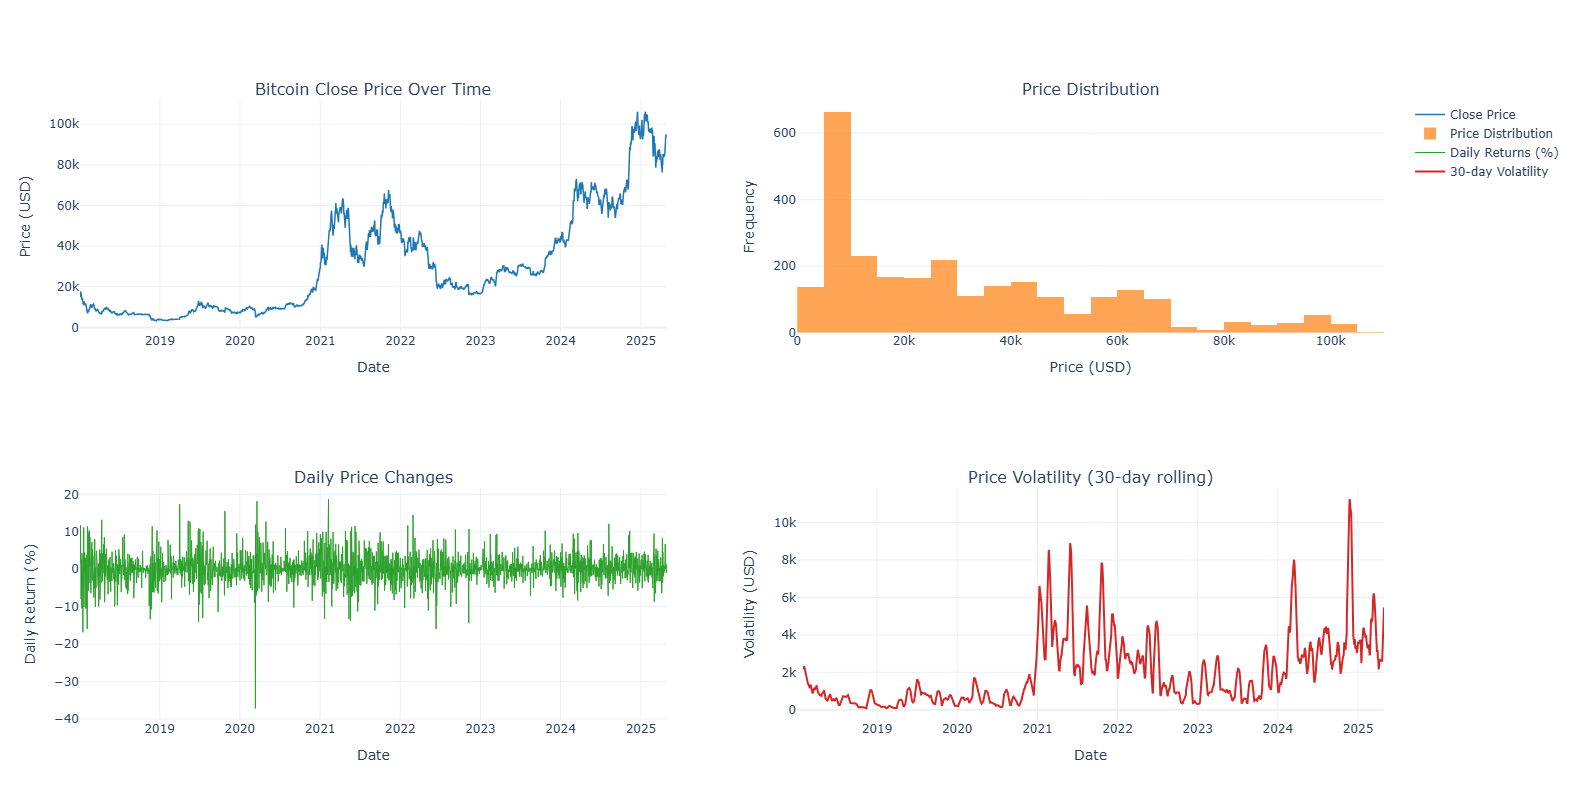

## 3. Xây dựng mô hình Transformer

In [47]:
# Time2Vector Sine Activation for time series
class SineActivation(nn.Module):
    """Time2Vector layer that adds periodic and linear features to input data"""

    def __init__(self, in_features, periodic_features, out_features, dropout=0.1):
        super(SineActivation, self).__init__()

        # Trọng số biến đổi tuyến tính
        linear_features = out_features - in_features - periodic_features
        self.w0 = nn.Parameter(torch.randn(in_features, linear_features))
        self.b0 = nn.Parameter(torch.randn(1, linear_features))

        # Trọng số biến đổi tuần hoàn
        self.w = nn.Parameter(torch.randn(in_features, periodic_features))
        self.b = nn.Parameter(torch.randn(1, periodic_features))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Tensor đầu vào có dạng [seq_len, batch_size, in_features]
        Returns:
            Tensor đã được tăng cường có dạng [seq_len, batch_size, out_features]
        """
        # Đặc trưng tuyến tính
        v_linear = torch.matmul(x, self.w0) + self.b0

        # Đặc trưng tuần hoàn sử dụng hàm kích hoạt sine
        v_periodic = torch.sin(torch.matmul(x, self.w) + self.b)

        # Nối tất cả các đặc trưng: [tuyến tính, tuần hoàn, gốc]
        output = torch.cat([v_linear, v_periodic, x], dim=-1)

        return self.dropout(output)

# Kiểm tra lớp SineActivation
test_sine = SineActivation(in_features=10, periodic_features=5, out_features=20)
test_input = torch.randn(32, 16, 10)  # [seq_len, batch_size, features]
test_output = test_sine(test_input)
print(f"Kiểm tra SineActivation - Kích thước đầu vào: {test_input.shape}, Kích thước đầu ra: {test_output.shape}")

Kiểm tra SineActivation - Kích thước đầu vào: torch.Size([32, 16, 10]), Kích thước đầu ra: torch.Size([32, 16, 20])


In [48]:
# Bitcoin Price Transformer Model
class BitcoinTransformer(nn.Module):
    """Transformer model for Bitcoin price prediction"""

    def __init__(self,
                 in_features,
                 periodic_features=8,
                 out_features=64,
                 nhead=8,
                 num_encoder_layers=6,
                 num_decoder_layers=6,
                 dim_feedforward=512,
                 dropout=0.1,
                 activation='relu'):
        super(BitcoinTransformer, self).__init__()

        self.in_features = in_features
        self.out_features = out_features

        # Time2Vector embedding layer
        self.sine_activation = SineActivation(
            in_features=in_features,
            periodic_features=periodic_features,
            out_features=out_features,
            dropout=dropout
        )

        # Transformer
        self.transformer = nn.Transformer(
            d_model=out_features,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=False
        )

        # Output projection layer
        self.generator = nn.Linear(out_features, in_features)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None,
                src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Forward pass of the transformer

        Args:
            src: Source sequence [src_len, batch_size, in_features]
            tgt: Target sequence [tgt_len, batch_size, in_features]
            masks: Various attention masks

        Returns:
            Output predictions [tgt_len, batch_size, in_features]
        """
        # Áp dụng sine activation cho cả nguồn và đích
        src_embedded = self.sine_activation(src)
        tgt_embedded = self.sine_activation(tgt)

        # Truyền qua transformer
        transformer_out = self.transformer(
            src=src_embedded,
            tgt=tgt_embedded,
            src_mask=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=memory_mask,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )

        # Chiếu trở lại không gian đặc trưng gốc
        output = self.generator(transformer_out)

        return output

    def generate_square_subsequent_mask(self, sz):
        """Generate a square mask for the sequence to prevent attending to future positions"""
        mask = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
        return mask

# Kiểm tra mô hình transformer
test_model = BitcoinTransformer(in_features=20, out_features=64, nhead=8)
test_src = torch.randn(10, 4, 20)  # [src_len, batch_size, features]
test_tgt = torch.randn(5, 4, 20)   # [tgt_len, batch_size, features]

# Tạo các attention mask
src_mask = torch.zeros(10, 10, dtype=torch.bool)
tgt_mask = test_model.generate_square_subsequent_mask(5)

test_output = test_model(test_src, test_tgt, src_mask=src_mask, tgt_mask=tgt_mask)
print(f"Kiểm tra Transformer - Kích thước đầu ra: {test_output.shape}")

Kiểm tra Transformer - Kích thước đầu ra: torch.Size([5, 4, 20])


In [49]:
class Config:
    # Data parameters
    in_features = modeling_data.shape[1]  # Number of input features
    target_feature = 0  # Index of target feature (price column)

    # Model architecture
    d_model = 128  # Model dimension (increased from out_features)
    nhead = 8  # Number of attention heads
    num_encoder_layers = 6  # Increased for better pattern learning
    num_decoder_layers = 3  # Fewer than encoder (asymmetric)
    dim_feedforward = 512  # Increased feedforward dimension
    dropout = 0.1
    activation = 'gelu'  # Better than ReLU for transformers

    # Positional encoding
    max_seq_length = 1000  # Maximum sequence length for positional encoding

    # Sequence parameters
    src_len = 15  # Input sequence length (slightly increased)
    tgt_len = 5   # Output prediction length
    overlap = 1   # Overlap between sequences

    # Training parameters
    batch_size = 64  # Increased batch size
    learning_rate = 0.0001  # Lower initial learning rate
    num_epochs = 200  # More epochs with better scheduling
    patience = 20  # Early stopping patience

    # Learning rate scheduling
    use_scheduler = True
    scheduler_type = 'cosine_warm_restarts'  # or 'reduce_on_plateau'
    warmup_epochs = 10
    T_0 = 20  # For CosineAnnealingWarmRestarts
    T_mult = 2
    eta_min = 1e-7

    # Regularization
    weight_decay = 1e-4
    label_smoothing = 0.0  # For classification tasks
    gradient_clip_val = 1.0  # Gradient clipping

    # Model initialization
    init_type = 'xavier_uniform'  # or 'kaiming_normal'

    # Data preprocessing
    normalize_features = True
    feature_scaling = 'standard'  # 'standard', 'minmax', or 'robust'

    # Validation and testing
    train_split = 0.7
    val_split = 0.15
    test_split = 0.15

    # Model checkpointing
    save_best_model = True
    checkpoint_dir = './checkpoints'
    model_name = 'transformer_forecaster'

    # Loss function
    loss_function = 'mse'  # 'mse', 'mae', 'huber', 'mape'
    huber_delta = 1.0  # For huber loss

    # Optimizer
    optimizer_type = 'adamw'  # 'adam', 'adamw', 'rmsprop'
    betas = (0.9, 0.999)
    eps = 1e-8

    # Advanced features
    use_attention_visualization = True
    use_mixed_precision = False  # For faster training on compatible GPUs

    # Multi-step prediction
    prediction_horizon = [1, 3, 5]  # Predict multiple horizons
    multi_task_learning = False

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_workers = 4  # For DataLoader
    pin_memory = True

    # Logging and monitoring
    log_interval = 10  # Log every N batches
    save_predictions = True
    plot_predictions = True

    # Model ensemble (optional)
    use_ensemble = False
    ensemble_size = 5

    # Time-based features
    add_time_features = True
    time_features = ['hour', 'day_of_week', 'month', 'quarter']
    cyclical_encoding = True  # Encode time features cyclically

    # Technical indicators (if applicable)
    add_technical_indicators = True
    indicators = ['sma_5', 'sma_20', 'rsi', 'macd', 'bollinger_bands']

    # Cross-validation
    use_time_series_cv = True
    cv_folds = 5

    @classmethod
    def get_optimizer(cls, model_parameters):
        """Get optimizer based on configuration"""
        if cls.optimizer_type == 'adam':
            return torch.optim.Adam(
                model_parameters,
                lr=cls.learning_rate,
                betas=cls.betas,
                eps=cls.eps,
                weight_decay=cls.weight_decay
            )
        elif cls.optimizer_type == 'adamw':
            return torch.optim.AdamW(
                model_parameters,
                lr=cls.learning_rate,
                betas=cls.betas,
                eps=cls.eps,
                weight_decay=cls.weight_decay
            )
        elif cls.optimizer_type == 'rmsprop':
            return torch.optim.RMSprop(
                model_parameters,
                lr=cls.learning_rate,
                weight_decay=cls.weight_decay
            )

    @classmethod
    def get_scheduler(cls, optimizer):
        """Get learning rate scheduler based on configuration"""
        if not cls.use_scheduler:
            return None

        if cls.scheduler_type == 'cosine_warm_restarts':
            return CosineAnnealingWarmRestarts(
                optimizer,
                T_0=cls.T_0,
                T_mult=cls.T_mult,
                eta_min=cls.eta_min
            )
        elif cls.scheduler_type == 'reduce_on_plateau':
            return torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=cls.patience // 2,
                min_lr=cls.eta_min
            )

    @classmethod
    def get_loss_function(cls):
        """Get loss function based on configuration"""
        if cls.loss_function == 'mse':
            return nn.MSELoss()
        elif cls.loss_function == 'mae':
            return nn.L1Loss()
        elif cls.loss_function == 'huber':
            return nn.SmoothL1Loss(delta=cls.huber_delta)
        elif cls.loss_function == 'mape':
            def mape_loss(y_pred, y_true):
                return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
            return mape_loss

    @classmethod
    def validate_config(cls):
        """Validate configuration parameters"""
        assert cls.d_model % cls.nhead == 0, "d_model must be divisible by nhead"
        assert cls.src_len > 0, "src_len must be positive"
        assert cls.tgt_len > 0, "tgt_len must be positive"
        assert 0 < cls.dropout < 1, "dropout must be between 0 and 1"
        assert cls.train_split + cls.val_split + cls.test_split == 1.0, "Splits must sum to 1.0"

        print("Configuration validation passed!")
        return True

# Validate configuration on import
Config.validate_config()

Configuration validation passed!


True

In [50]:
# Initialize model with updated config parameters
model = BitcoinTransformer(
    in_features=Config.in_features,
    out_features=Config.d_model,  # Changed from out_features to d_model
    nhead=Config.nhead,
    num_encoder_layers=Config.num_encoder_layers,
    num_decoder_layers=Config.num_decoder_layers,
    dim_feedforward=Config.dim_feedforward,
    dropout=Config.dropout,
    activation=Config.activation,
).to(Config.device)

# Apply weight initialization
def init_weights(module):
    if isinstance(module, (nn.Linear, nn.Conv1d)):
        if Config.init_type == 'xavier_uniform':
            nn.init.xavier_uniform_(module.weight)
        elif Config.init_type == 'kaiming_normal':
            nn.init.kaiming_normal_(module.weight)
        elif Config.init_type == 'normal':
            nn.init.normal_(module.weight, mean=0, std=0.02)

        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

    elif isinstance(module, nn.LayerNorm):
        nn.init.constant_(module.bias, 0)
        nn.init.constant_(module.weight, 1.0)

# Apply initialization
model.apply(init_weights)

# Get model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Mô hình đã khởi tạo thành công!")
print(f"Tổng số tham số: {total_params:,}")
print(f"Tham số có thể huấn luyện: {trainable_params:,}")
print(f"Kích thước mô hình: {total_params * 4 / 1024 / 1024:.2f} MB")
print(f"Device: {Config.device}")

# Initialize optimizer and scheduler
optimizer = Config.get_optimizer(model.parameters())
scheduler = Config.get_scheduler(optimizer)
criterion = Config.get_loss_function()

print(f"- Optimizer: {Config.optimizer_type}")
print(f"- Scheduler: {Config.scheduler_type if Config.use_scheduler else 'None'}")
print(f"- Loss function: {Config.loss_function}")

Mô hình đã khởi tạo thành công!
Tổng số tham số: 1,985,743
Tham số có thể huấn luyện: 1,985,743
Kích thước mô hình: 7.58 MB
Device: cuda
- Optimizer: adamw
- Scheduler: cosine_warm_restarts
- Loss function: mse


## 4. Chuẩn bị dữ liệu & Hàm huấn luyện

In [51]:
def train_test_split(data, test_ratio=0.2):
    """Chia dữ liệu thành tập train và test (80/20)"""
    n = len(data)

    train_size = int(n * (1 - test_ratio))

    train_data = data[:train_size]
    test_data = data[train_size:]

    return train_data, test_data

def normalize_data(train_data, test_data):
    """Chuẩn hóa dữ liệu sử dụng thống kê từ tập huấn luyện"""
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    # Fit trên dữ liệu huấn luyện
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    return (torch.FloatTensor(train_scaled),
            torch.FloatTensor(test_scaled),
            scaler)

def create_sequences(data, src_len, tgt_len, overlap=1):
    """Tạo các chuỗi cho việc huấn luyện transformer"""
    sequences = []
    targets = []

    for i in range(len(data) - src_len - tgt_len + overlap):
        src_seq = data[i:i + src_len]
        tgt_seq = data[i + src_len - overlap:i + src_len + tgt_len - overlap]

        sequences.append(src_seq)
        targets.append(tgt_seq)

    return torch.stack(sequences), torch.stack(targets)

def create_data_loader(sequences, targets, batch_size, shuffle=True):
    """Tạo PyTorch DataLoader"""
    from torch.utils.data import TensorDataset, DataLoader

    dataset = TensorDataset(sequences, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Chia dữ liệu
train_data, test_data = train_test_split(modeling_data.values, test_ratio=0.2)
print(f"Train: {train_data.shape}, Test: {test_data.shape}")

# Chuẩn hóa dữ liệu
train_norm, test_norm, scaler = normalize_data(train_data, test_data)
print("Dữ liệu đã được chuẩn hóa thành công")

Train: (2140, 7), Test: (535, 7)
Dữ liệu đã được chuẩn hóa thành công


In [52]:
# Tạo chuỗi và data loaders
print("Tạo chuỗi...")
train_seq, train_tgt = create_sequences(train_norm, Config.src_len, Config.tgt_len, Config.overlap)
test_seq, test_tgt = create_sequences(test_norm, Config.src_len, Config.tgt_len, Config.overlap)

print(f"Chuỗi train: {train_seq.shape}, targets: {train_tgt.shape}")
print(f"Chuỗi test: {test_seq.shape}, targets: {test_tgt.shape}")

# Tạo data loaders
train_loader = create_data_loader(train_seq, train_tgt, Config.batch_size, shuffle=True)
test_loader = create_data_loader(test_seq, test_tgt, Config.batch_size, shuffle=False)

print(f"Đã tạo data loaders với {len(train_loader)} batch train và {len(test_loader)} batch test")

Tạo chuỗi...
Chuỗi train: torch.Size([2121, 15, 7]), targets: torch.Size([2121, 5, 7])
Chuỗi test: torch.Size([516, 15, 7]), targets: torch.Size([516, 5, 7])
Đã tạo data loaders với 34 batch train và 9 batch test


In [53]:
# Hàm huấn luyện và đánh giá
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Huấn luyện mô hình trong một epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for _, (src_seq, tgt_seq) in enumerate(train_loader):
        # Di chuyển đến thiết bị và chuyển vị cho transformer (seq_len, batch_size, features)
        src = src_seq.transpose(0, 1).to(device)
        tgt = tgt_seq.transpose(0, 1).to(device)

        # Tạo masks
        src_mask = torch.zeros(src.size(0), src.size(0), dtype=torch.bool).to(device)
        tgt_mask = model.generate_square_subsequent_mask(tgt.size(0)).to(device)

        # Tiến trình xuôi
        optimizer.zero_grad()

        # Sử dụng teacher forcing: đầu vào là tgt[:-1], mục tiêu là tgt[1:]
        tgt_input = tgt[:-1]
        tgt_output = tgt[1:]

        output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask[:-1, :-1])

        # Tính toán mất mát chỉ trên đặc trưng mục tiêu
        loss = criterion(output[:, :, Config.target_feature], tgt_output[:, :, Config.target_feature])

        # Tiến trình ngược
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.gradient_clip_val)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate_model(model, data_loader, criterion, device):
    """Đánh giá mô hình trên tập test"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for src_seq, tgt_seq in data_loader:
            # Di chuyển đến thiết bị và chuyển vị
            src = src_seq.transpose(0, 1).to(device)
            tgt = tgt_seq.transpose(0, 1).to(device)

            # Tạo masks
            src_mask = torch.zeros(src.size(0), src.size(0), dtype=torch.bool).to(device)
            tgt_mask = model.generate_square_subsequent_mask(tgt.size(0)).to(device)

            # Tiến trình xuôi
            tgt_input = tgt[:-1]
            tgt_output = tgt[1:]

            output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask[:-1, :-1])

            # Tính toán mất mát
            loss = criterion(output[:, :, Config.target_feature], tgt_output[:, :, Config.target_feature])

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

print("Verifying components from previous initialization...")
print(f"- Model exists: {model is not None}")
print(f"- Optimizer exists: {optimizer is not None}")
print(f"- Criterion exists: {criterion is not None}")
print(f"- Scheduler exists: {scheduler is not None}")
print(f"- Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"- Optimizer type: {type(optimizer).__name__}")
print(f"- Scheduler type: {type(scheduler).__name__}")

Verifying components from previous initialization...
- Model exists: True
- Optimizer exists: True
- Criterion exists: True
- Scheduler exists: True
- Model parameters: 1,985,743
- Optimizer type: AdamW
- Scheduler type: CosineAnnealingWarmRestarts


In [54]:
# Vòng lặp huấn luyện
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience_counter = 0

print("Bắt đầu huấn luyện...")
for epoch in range(Config.num_epochs):
    # Huấn luyện
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Đánh giá trên tập test mỗi 5 epoch để tiết kiệm thời gian
    if (epoch + 1) % 5 == 0:
        test_loss = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)

        # Lịch trình điều chỉnh learning rate
        scheduler.step(test_loss)

        # Dừng sớm dựa trên test loss
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            # Lưu mô hình tốt nhất
            torch.save(model.state_dict(), 'best_bitcoin_transformer.pth')
        else:
            patience_counter += 1

        # In tiến trình
        print(f'Epoch [{epoch+1}/{Config.num_epochs}], Mất mát huấn luyện: {train_loss:.6f}, Mất mát test: {test_loss:.6f}')

        # Dừng sớm
        if patience_counter >= Config.patience // 5:  # Điều chỉnh patience vì chỉ kiểm tra mỗi 5 epoch
            print(f'Dừng sớm tại epoch {epoch+1}')
            break
    else:
        # Chỉ in train loss cho các epoch khác
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{Config.num_epochs}], Mất mát huấn luyện: {train_loss:.6f}')

print(f'Hoàn thành huấn luyện. Test loss tốt nhất: {best_test_loss:.6f}')

Bắt đầu huấn luyện...
Epoch [5/200], Mất mát huấn luyện: 0.054287, Mất mát test: 0.865665
Epoch [10/200], Mất mát huấn luyện: 0.026717, Mất mát test: 0.861048
Epoch [15/200], Mất mát huấn luyện: 0.022678, Mất mát test: 1.337056
Epoch [20/200], Mất mát huấn luyện: 0.017077, Mất mát test: 1.367281
Epoch [25/200], Mất mát huấn luyện: 0.015804, Mất mát test: 1.548664
Epoch [30/200], Mất mát huấn luyện: 0.013095, Mất mát test: 1.649169
Dừng sớm tại epoch 30
Hoàn thành huấn luyện. Test loss tốt nhất: 0.861048


Final Test Loss: 0.861048


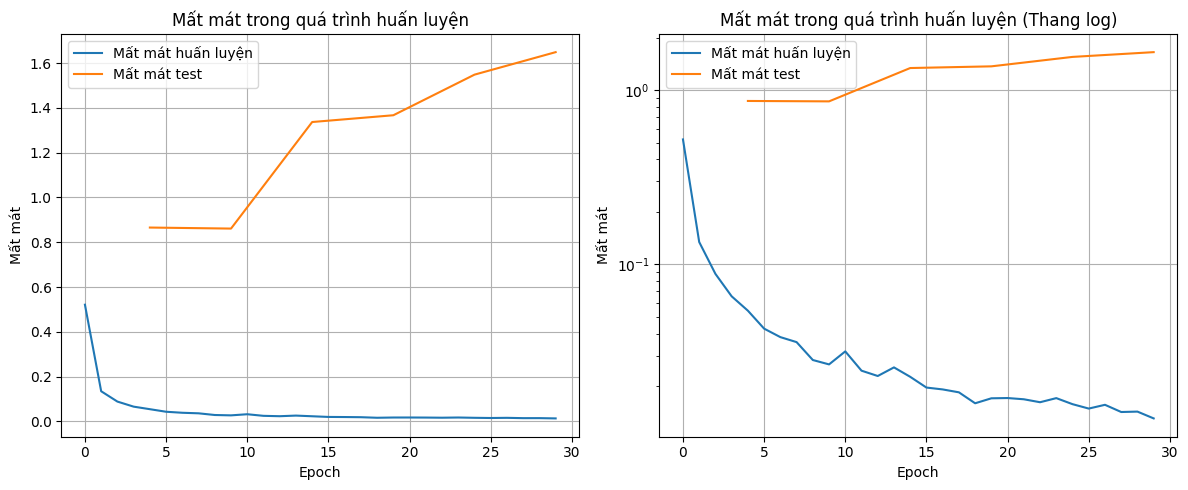

In [55]:
# Tải mô hình tốt nhất và đánh giá cuối cùng trên tập test
model.load_state_dict(torch.load('best_bitcoin_transformer.pth'))
final_test_loss = evaluate_model(model, test_loader, criterion, device)
print(f'Final Test Loss: {final_test_loss:.6f}')

# Vẽ biểu đồ mất mát trong quá trình huấn luyện
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Mất mát huấn luyện')
# Tạo x-axis cho test losses (chỉ được tính mỗi 5 epoch)
test_epochs = list(range(4, len(train_losses), 5))[:len(test_losses)]
plt.plot(test_epochs, test_losses, label='Mất mát test')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.title('Mất mát trong quá trình huấn luyện')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Mất mát huấn luyện')
plt.plot(test_epochs, test_losses, label='Mất mát test')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.title('Mất mát trong quá trình huấn luyện (Thang log)')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Dự đoán & Trực quan hóa kết quả

In [56]:
def predict_test_dataset_detailed(model, test_loader, scaler, device, data_clean, Config):
    """Tạo dự đoán chi tiết cho từng ngày trong tập test"""

    model.eval()
    all_detailed_predictions = []

    # Lấy cột ngày
    date_col = None
    if 'date' in data_clean.columns:
        date_col = 'date'
    elif 'timestamp' in data_clean.columns:
        date_col = 'timestamp'

    # Lấy cột giá
    price_columns = [col for col in data_clean.columns if any(keyword in col.lower() for keyword in ['close', 'price', 'closing'])]
    if price_columns:
        price_col = price_columns[0]
    else:
        numeric_cols = data_clean.select_dtypes(include=[np.number]).columns
        price_col = numeric_cols[0]

    batch_idx = 0
    sample_idx = 0

    with torch.no_grad():
        for src_seq, tgt_seq in test_loader:
            batch_size = src_seq.size(0)

            # Di chuyển dữ liệu lên device và chuyển vị
            src = src_seq.transpose(0, 1).to(device)
            tgt = tgt_seq.transpose(0, 1).to(device)

            # Tạo masks
            src_mask = torch.zeros(src.size(0), src.size(0), dtype=torch.bool).to(device)
            tgt_mask = model.generate_square_subsequent_mask(tgt.size(0)).to(device)

            # Dự đoán autoregressive cho từng mẫu trong batch
            for b in range(batch_size):
                src_single = src[:, b:b+1, :]  # Lấy một mẫu
                tgt_single = tgt[:, b:b+1, :]

                # Dự đoán từng bước
                tgt_input = tgt_single[0:1]
                predictions = []

                for step in range(tgt_single.size(0) - 1):
                    output = model(src_single, tgt_input,
                                 src_mask=src_mask[:src_single.size(0), :src_single.size(0)],
                                 tgt_mask=tgt_mask[:tgt_input.size(0), :tgt_input.size(0)])

                    next_pred = output[-1:, :, :]
                    predictions.append(next_pred.cpu().numpy())
                    tgt_input = torch.cat([tgt_input, next_pred], dim=0)

                # Chuyển đổi về thang đo gốc
                predictions_np = np.concatenate(predictions, axis=0)  # [steps, 1, features]
                targets_np = tgt_single[1:].cpu().numpy()  # [steps, 1, features]

                # Tạo dummy arrays để inverse transform
                dummy_pred = np.zeros((predictions_np.shape[0], scaler.n_features_in_))
                dummy_tgt = np.zeros((targets_np.shape[0], scaler.n_features_in_))

                dummy_pred[:, :predictions_np.shape[2]] = predictions_np[:, 0, :]
                dummy_tgt[:, :targets_np.shape[2]] = targets_np[:, 0, :]

                pred_original = scaler.inverse_transform(dummy_pred)
                tgt_original = scaler.inverse_transform(dummy_tgt)

                # Lấy giá dự đoán và thực tế
                pred_prices = pred_original[:, Config.target_feature]
                actual_prices = tgt_original[:, Config.target_feature]

                # Tính toán ngày dự đoán với split mới (80/20)
                total_samples_before = batch_idx * test_loader.batch_size + sample_idx

                # Tính chỉ số trong dataset gốc (train + test)
                train_size = int(len(data_clean) * 0.8)  # 80% train
                test_start_idx = train_size

                # Chỉ số bắt đầu của chuỗi này trong dataset gốc
                sequence_start_idx = test_start_idx + total_samples_before

                # Lưu thông tin chi tiết cho từng bước dự đoán
                for step in range(len(pred_prices)):
                    day_idx = sequence_start_idx + Config.src_len + step

                    if day_idx < len(data_clean):
                        if date_col:
                            prediction_date = pd.to_datetime(data_clean.iloc[day_idx][date_col])
                            date_str = prediction_date.strftime('%d/%m/%Y')
                        else:
                            date_str = f"Ngày {day_idx + 1}"

                        # Lấy giá thực tế từ dataset gốc
                        actual_price_from_data = data_clean.iloc[day_idx][price_col]

                        prediction_info = {
                            'sample_idx': total_samples_before,
                            'step': step + 1,
                            'date': date_str,
                            'day_idx': day_idx,
                            'predicted_price': pred_prices[step],
                            'actual_price': actual_prices[step],
                            'actual_price_original': actual_price_from_data,
                            'absolute_error': abs(pred_prices[step] - actual_prices[step]),
                            'percentage_error': abs(pred_prices[step] - actual_prices[step]) / actual_prices[step] * 100,
                            'prediction_direction': 'Tăng' if step > 0 and pred_prices[step] > pred_prices[step-1] else 'Giảm' if step > 0 else 'Cơ sở'
                        }

                        all_detailed_predictions.append(prediction_info)

                sample_idx += 1

            batch_idx += 1

    return pd.DataFrame(all_detailed_predictions)

# Tạo dự đoán chi tiết
print("Đang tạo dự đoán chi tiết cho tập test...")
detailed_predictions_df = predict_test_dataset_detailed(model, test_loader, scaler, device, data_clean, Config)

print(f"Đã tạo {len(detailed_predictions_df)} dự đoán chi tiết")
print(f"Số mẫu duy nhất: {detailed_predictions_df['sample_idx'].nunique()}")
print(f"Số bước dự đoán trung bình mỗi mẫu: {detailed_predictions_df.groupby('sample_idx').size().mean():.1f}")

Đang tạo dự đoán chi tiết cho tập test...
Đã tạo 1050 dự đoán chi tiết
Số mẫu duy nhất: 264
Số bước dự đoán trung bình mỗi mẫu: 4.0


In [57]:
print("THỐNG KÊ TỔNG QUAN DỰ ĐOÁN TẬP TEST")
print("="*80)

print(f"Tổng số dự đoán: {len(detailed_predictions_df):,}")
print(f"Khoảng ngày dự đoán: {detailed_predictions_df['date'].min()} đến {detailed_predictions_df['date'].max()}")
print(f"Giá trung bình thực tế: ${detailed_predictions_df['actual_price'].mean():,.2f}")
print(f"Giá trung bình dự đoán: ${detailed_predictions_df['predicted_price'].mean():,.2f}")
print(f"Sai số tuyệt đối trung bình: ${detailed_predictions_df['absolute_error'].mean():,.2f}")
print(f"Sai số phần trăm trung bình: {detailed_predictions_df['percentage_error'].mean():.2f}%")
print(f"Độ lệch chuẩn sai số: ${detailed_predictions_df['absolute_error'].std():,.2f}")

# Hiển thị 20 dự đoán đầu tiên
print("\n" + "="*80)
print("20 DỰ ĐOÁN ĐẦU TIÊN TRONG TẬP TEST")
print("="*80)

display_columns = ['date', 'predicted_price', 'actual_price', 'absolute_error', 'percentage_error', 'prediction_direction']
first_20 = detailed_predictions_df.head(20)[display_columns].copy()

# Format lại để hiển thị đẹp
first_20['predicted_price'] = first_20['predicted_price'].apply(lambda x: f"${x:,.2f}")
first_20['actual_price'] = first_20['actual_price'].apply(lambda x: f"${x:,.2f}")
first_20['absolute_error'] = first_20['absolute_error'].apply(lambda x: f"${x:,.2f}")
first_20['percentage_error'] = first_20['percentage_error'].apply(lambda x: f"{x:.2f}%")

print(first_20.to_string(index=False))

THỐNG KÊ TỔNG QUAN DỰ ĐOÁN TẬP TEST
Tổng số dự đoán: 1,050
Khoảng ngày dự đoán: 01/01/2024 đến 31/12/2024
Giá trung bình thực tế: $57,754.82
Giá trung bình dự đoán: $56,645.94
Sai số tuyệt đối trung bình: $2,637.08
Sai số phần trăm trung bình: 4.58%
Độ lệch chuẩn sai số: $2,305.01

20 DỰ ĐOÁN ĐẦU TIÊN TRONG TẬP TEST
      date predicted_price actual_price absolute_error percentage_error prediction_direction
27/11/2023      $37,326.59   $37,254.17         $72.42            0.19%                Cơ sở
28/11/2023      $35,947.77   $37,831.09      $1,883.32            4.98%                 Giảm
29/11/2023      $35,541.96   $37,858.49      $2,316.53            6.12%                 Giảm
30/11/2023      $35,284.78   $37,712.75      $2,427.97            6.44%                 Giảm
28/11/2023      $37,521.55   $37,831.09        $309.54            0.82%                Cơ sở
29/11/2023      $36,265.78   $37,858.49      $1,592.71            4.21%                 Giảm
30/11/2023      $35,863.88   $3

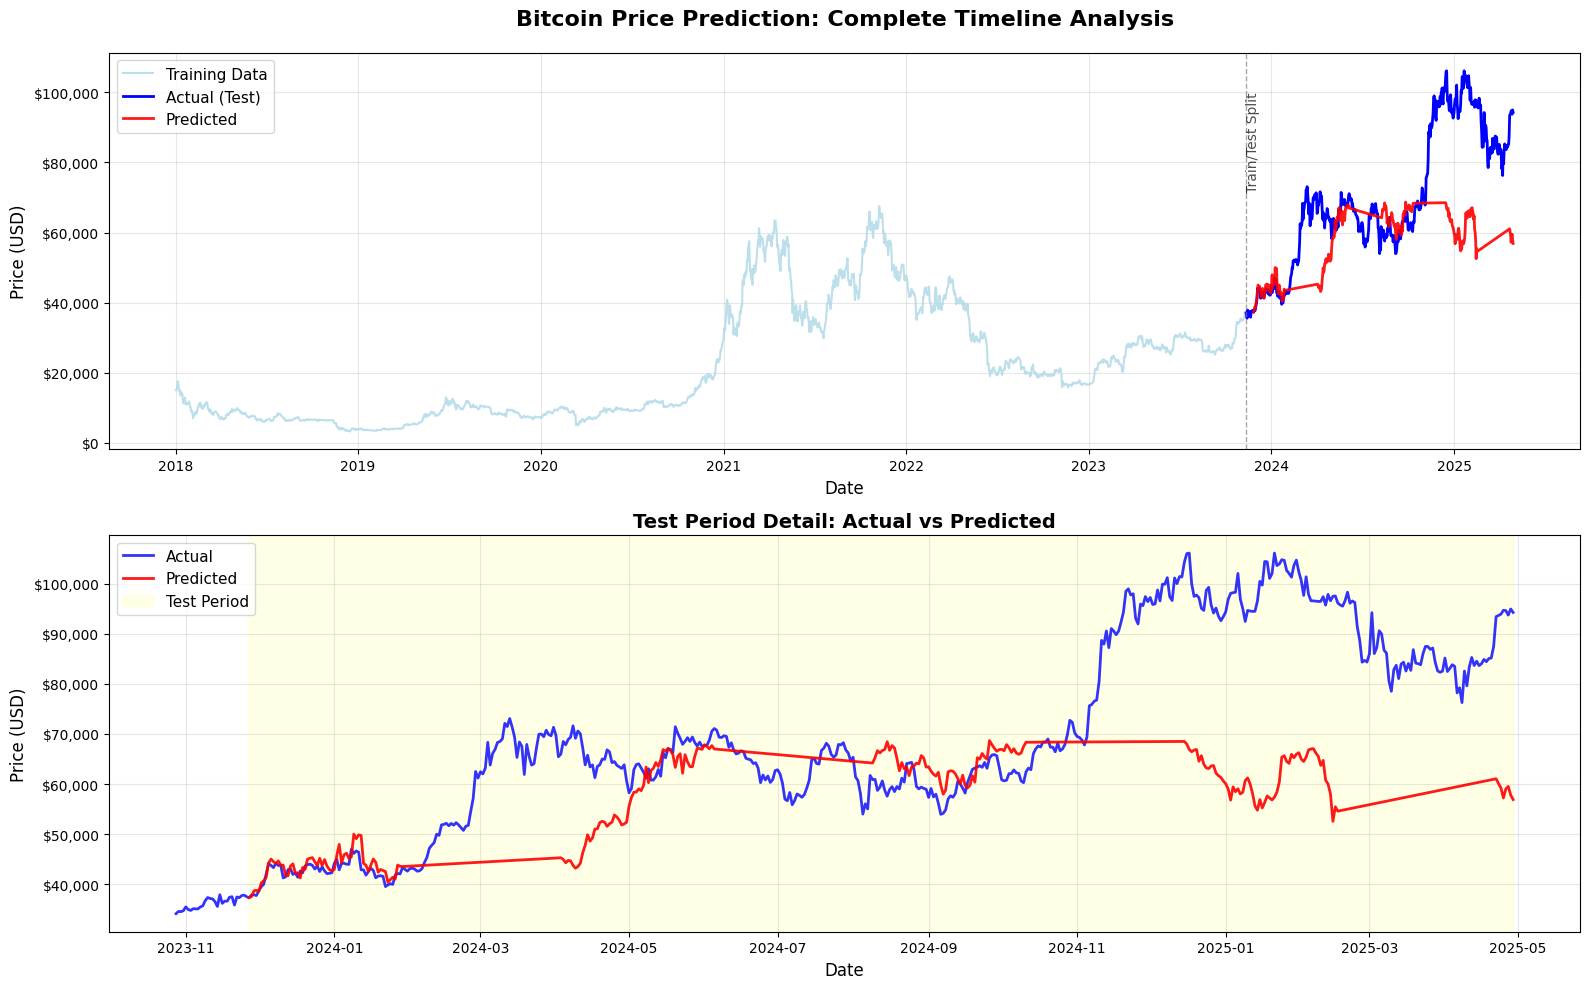

In [58]:
def create_comprehensive_timeline_plot(detailed_predictions_df, data_clean, Config):
    """Tạo biểu đồ timeline toàn diện cho toàn bộ dataset"""

    price_columns = [col for col in data_clean.columns if any(keyword in col.lower() for keyword in ['close', 'price', 'closing'])]
    if price_columns:
        price_col = price_columns[0]
    else:
        numeric_cols = data_clean.select_dtypes(include=[np.number]).columns
        price_col = numeric_cols[0]

    date_col = None
    if 'date' in data_clean.columns:
        date_col = 'date'
    elif 'timestamp' in data_clean.columns:
        date_col = 'timestamp'

    full_timeline = pd.DataFrame()
    full_timeline['date'] = pd.to_datetime(data_clean[date_col]) if date_col else pd.date_range(start='2020-01-01', periods=len(data_clean), freq='D')
    full_timeline['actual_price'] = data_clean[price_col].values
    full_timeline['data_type'] = 'Historical'

    train_size = int(len(data_clean) * 0.8)
    full_timeline.loc[train_size:, 'data_type'] = 'Test Period'

    pred_data = detailed_predictions_df[detailed_predictions_df['step'] == 1].copy()
    pred_data['date_parsed'] = pd.to_datetime(pred_data['date'], format='%d/%m/%Y')
    pred_data = pred_data.sort_values('date_parsed').reset_index(drop=True)

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 1, 1)

    train_data = full_timeline[:train_size]
    plt.plot(train_data['date'], train_data['actual_price'],
             color='lightblue', linewidth=1.5, alpha=0.8, label='Training Data')


    test_data = full_timeline[train_size:]
    plt.plot(test_data['date'], test_data['actual_price'],
             color='blue', linewidth=2, label='Actual (Test)')

    plt.plot(pred_data['date_parsed'], pred_data['predicted_price'],
             color='red', linewidth=2, label='Predicted', alpha=0.9)

    plt.axvline(x=train_data['date'].iloc[-1], color='gray', linestyle='--', alpha=0.7, linewidth=1)
    plt.text(train_data['date'].iloc[-1], plt.ylim()[1]*0.9, 'Train/Test Split',
             rotation=90, verticalalignment='top', fontsize=10, alpha=0.7)

    plt.title('Bitcoin Price Prediction: Complete Timeline Analysis', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    plt.subplot(2, 1, 2)

    test_start_date = pred_data['date_parsed'].min()
    test_end_date = pred_data['date_parsed'].max()

    padding_days = 30
    plot_start_date = test_start_date - pd.Timedelta(days=padding_days)

    mask_full = (full_timeline['date'] >= plot_start_date) & (full_timeline['date'] <= test_end_date)
    zoom_data = full_timeline[mask_full]

    plt.plot(zoom_data['date'], zoom_data['actual_price'],
             color='blue', linewidth=2, label='Actual', alpha=0.8)

    plt.plot(pred_data['date_parsed'], pred_data['predicted_price'],
             color='red', linewidth=2, label='Predicted', alpha=0.9)

    plt.axvspan(test_start_date, test_end_date, alpha=0.1, color='yellow', label='Test Period')

    plt.title('Test Period Detail: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3)

    # Format y-axis
    ax2 = plt.gca()
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    plt.tight_layout()
    plt.show()

    return full_timeline, pred_data

full_timeline, pred_data = create_comprehensive_timeline_plot(detailed_predictions_df, data_clean, Config)

Generating 30-day price predictions...


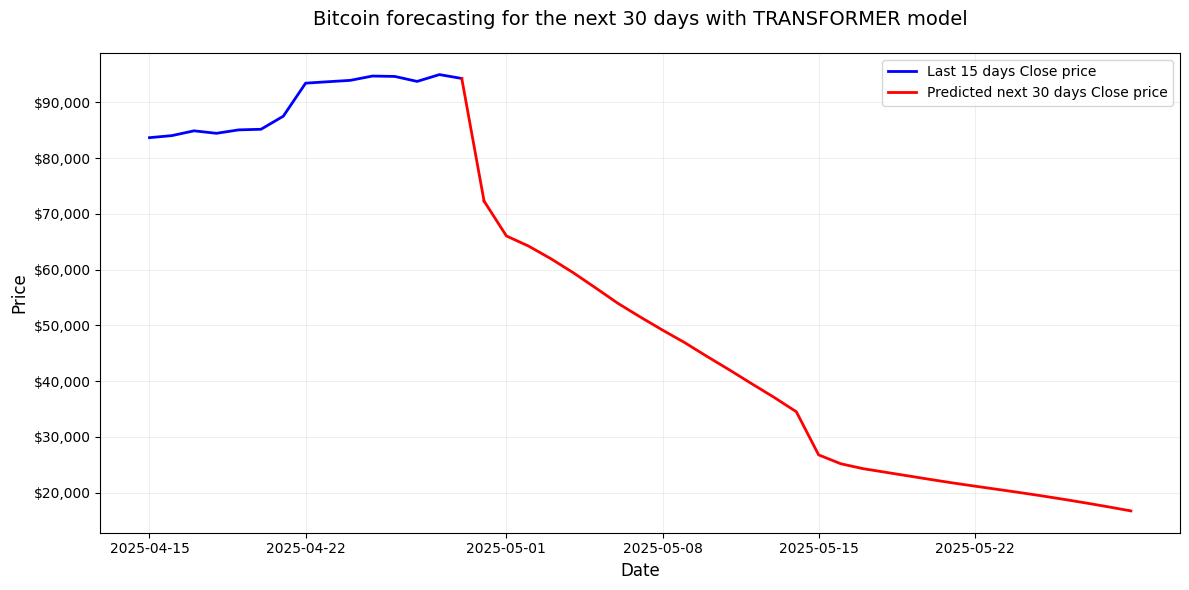

In [59]:
def predict_next_30_days_simple(model, data_clean, scaler, Config, device):
    """Predict Bitcoin prices for the next 30 days"""

    model.eval()

    # Get the last sequence from the dataset
    numeric_columns = data_clean.select_dtypes(include=[np.number]).columns.tolist()
    last_data = data_clean[numeric_columns].tail(Config.src_len).values

    # Normalize the last sequence
    last_data_normalized = scaler.transform(last_data)
    last_sequence = torch.FloatTensor(last_data_normalized).unsqueeze(1).to(device)

    # Initialize predictions list
    future_predictions = []
    current_sequence = last_sequence.clone()

    # Predict day by day for 30 days
    with torch.no_grad():
        for day in range(30):
            # Create target input
            tgt_input = current_sequence[-1:, :, :]

            # Create masks
            src_mask = torch.zeros(current_sequence.size(0), current_sequence.size(0), dtype=torch.bool).to(device)
            tgt_mask = model.generate_square_subsequent_mask(1).to(device)

            # Predict next day
            output = model(current_sequence, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask)

            # Get prediction
            next_pred = output[-1:, :, :].cpu().numpy()

            # Store prediction
            future_predictions.append(next_pred[0, 0, :])

            # Update sequence for next prediction
            next_pred_tensor = torch.FloatTensor(next_pred).to(device)
            current_sequence = torch.cat([current_sequence[1:], next_pred_tensor], dim=0)

    # Convert predictions back to original scale
    future_predictions = np.array(future_predictions)
    dummy_predictions = np.zeros((30, scaler.n_features_in_))
    dummy_predictions[:, :future_predictions.shape[1]] = future_predictions

    future_prices_original = scaler.inverse_transform(dummy_predictions)
    predicted_prices = future_prices_original[:, Config.target_feature]

    return predicted_prices

def create_price_prediction_chart(model, data_clean, scaler, Config, device):
    """Create a chart matching the reference style"""

    print("Generating 30-day price predictions...")
    predicted_prices = predict_next_30_days_simple(model, data_clean, scaler, Config, device)

    # Get price column
    price_columns = [col for col in data_clean.columns if any(keyword in col.lower() for keyword in ['close', 'price', 'closing'])]
    price_col = price_columns[0] if price_columns else data_clean.select_dtypes(include=[np.number]).columns[0]

    # Get date column
    date_col = 'date' if 'date' in data_clean.columns else ('timestamp' if 'timestamp' in data_clean.columns else None)

    # Get last 15 days of historical data for context
    historical_prices = data_clean[price_col].tail(15).values

    if date_col:
        historical_dates = pd.to_datetime(data_clean[date_col]).tail(15)
        last_date = pd.to_datetime(data_clean[date_col].iloc[-1])
    else:
        last_date = datetime.now()
        historical_dates = pd.date_range(end=last_date, periods=15, freq='D')

    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

    all_dates = list(historical_dates) + list(future_dates)
    all_prices = list(historical_prices) + list(predicted_prices)

    plt.figure(figsize=(12, 6))

    plt.plot(historical_dates, historical_prices,
             color='blue', linewidth=2, label='Last 15 days Close price')

    plt.plot(future_dates, predicted_prices,
             color='red', linewidth=2, label='Predicted next 30 days Close price')

    plt.plot([historical_dates.iloc[-1], future_dates[0]],
             [historical_prices[-1], predicted_prices[0]],
             color='red', linewidth=2)

    plt.title('Bitcoin forecasting for the next 30 days with TRANSFORMER model', fontsize=14, pad=20)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)

    plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=False)

    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    plt.xticks()

    plt.gca().set_facecolor('white')
    plt.tight_layout()

    plt.show()

    return predicted_prices, future_dates, historical_prices, historical_dates

predicted_prices, future_dates, historical_prices, historical_dates = create_price_prediction_chart(
    model, data_clean, scaler, Config, device)

## 6. Đánh giá mô hình

Evaluating model on test set...


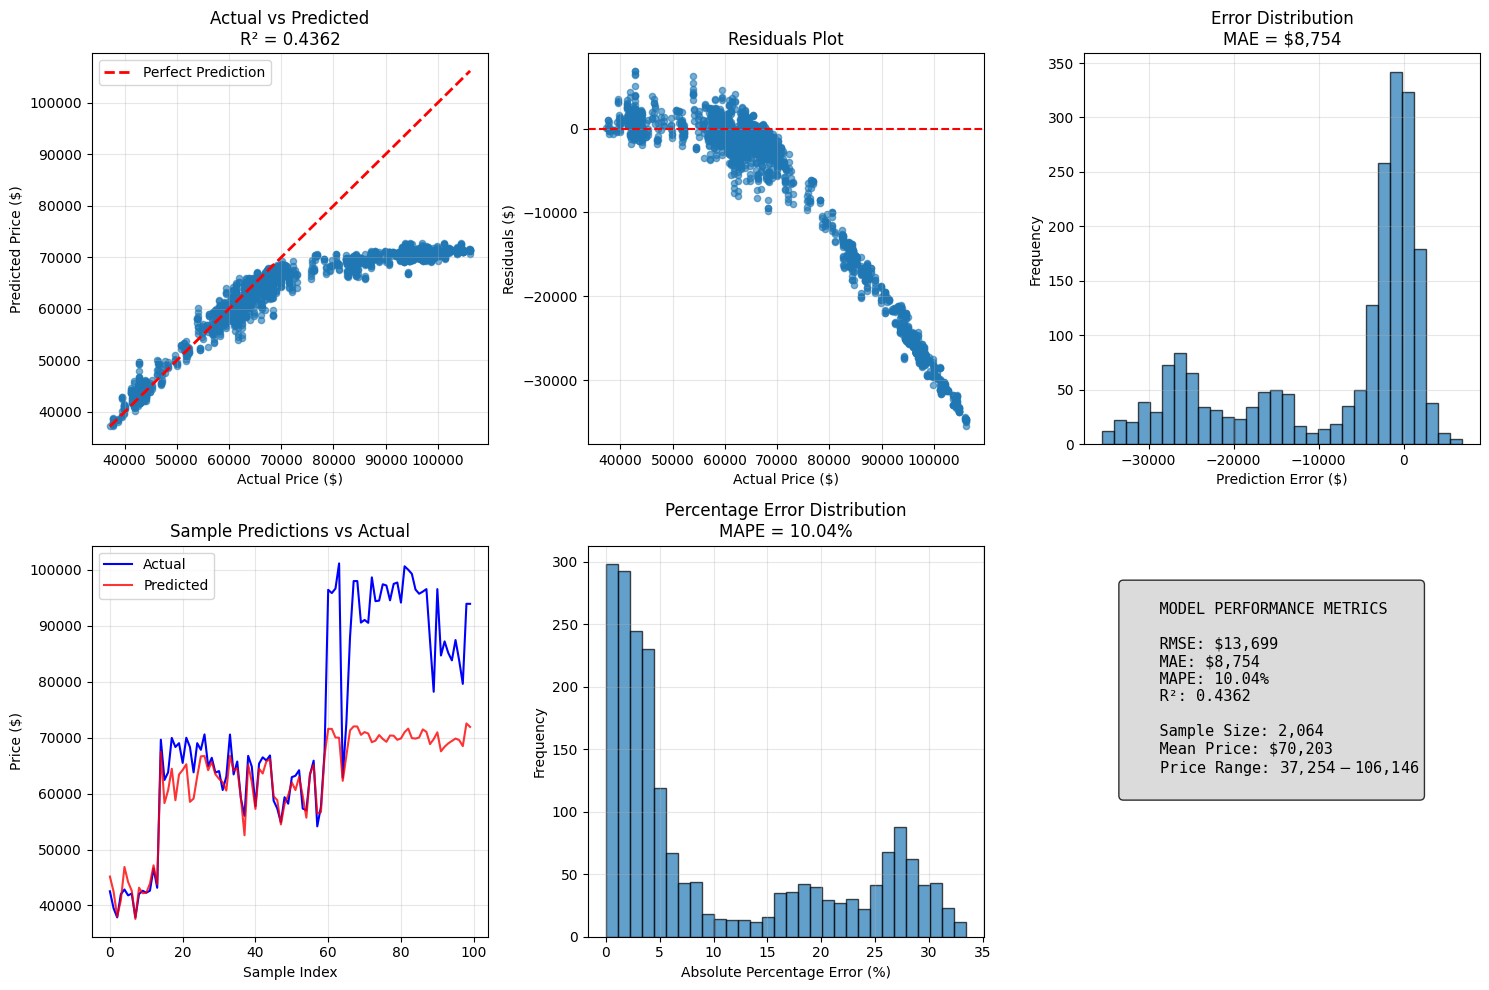

In [60]:
def calculate_prediction_metrics(actual_prices, predicted_prices):
    # Convert to numpy arrays
    actual = np.array(actual_prices)
    predicted = np.array(predicted_prices)

    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / np.where(actual == 0, 1e-8, actual))) * 100
    r2 = r2_score(actual, predicted)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

def evaluate_model_comprehensive(model, test_loader, scaler, Config, device):
    """Comprehensive model evaluation with all metrics"""

    model.eval()
    all_predictions = []
    all_actuals = []

    print("Evaluating model on test set...")

    with torch.no_grad():
        for src_seq, tgt_seq in test_loader:
            # Move to device and transpose
            src = src_seq.transpose(0, 1).to(device)
            tgt = tgt_seq.transpose(0, 1).to(device)

            # Create masks
            src_mask = torch.zeros(src.size(0), src.size(0), dtype=torch.bool).to(device)
            tgt_mask = model.generate_square_subsequent_mask(tgt.size(0)).to(device)

            # Forward pass
            tgt_input = tgt[:-1]
            tgt_output = tgt[1:]

            output = model(src, tgt_input, src_mask=src_mask, tgt_mask=tgt_mask[:-1, :-1])

            # Get predictions and actuals for target feature
            pred_prices = output[:, :, Config.target_feature].cpu().numpy()
            actual_prices = tgt_output[:, :, Config.target_feature].cpu().numpy()

            # Flatten and store
            all_predictions.extend(pred_prices.flatten())
            all_actuals.extend(actual_prices.flatten())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)

    # Inverse transform to get original scale
    # Create dummy arrays for inverse transform
    dummy_pred = np.zeros((len(all_predictions), scaler.n_features_in_))
    dummy_actual = np.zeros((len(all_actuals), scaler.n_features_in_))

    dummy_pred[:, Config.target_feature] = all_predictions
    dummy_actual[:, Config.target_feature] = all_actuals

    # Inverse transform
    pred_original = scaler.inverse_transform(dummy_pred)[:, Config.target_feature]
    actual_original = scaler.inverse_transform(dummy_actual)[:, Config.target_feature]

    # Calculate metrics
    metrics = calculate_prediction_metrics(actual_original, pred_original)

    return metrics, pred_original, actual_original

def create_metrics_visualization(actual_original, pred_original, metrics):
    """Create visualizations for metrics analysis"""

    plt.figure(figsize=(15, 10))

    # 1. Actual vs Predicted scatter plot
    plt.subplot(2, 3, 1)
    plt.scatter(actual_original, pred_original, alpha=0.6, s=20)

    # Perfect prediction line
    min_val = min(actual_original.min(), pred_original.min())
    max_val = max(actual_original.max(), pred_original.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f'Actual vs Predicted\nR² = {metrics["R²"]:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Residuals plot
    plt.subplot(2, 3, 2)
    residuals = pred_original - actual_original
    plt.scatter(actual_original, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Residuals ($)')
    plt.title('Residuals Plot')
    plt.grid(True, alpha=0.3)

    # 3. Error distribution
    plt.subplot(2, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error ($)')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution\nMAE = ${metrics["MAE"]:,.0f}')
    plt.grid(True, alpha=0.3)

    # 4. Time series of predictions (sample)
    plt.subplot(2, 3, 4)
    sample_size = min(100, len(actual_original))
    sample_indices = np.random.choice(len(actual_original), sample_size, replace=False)
    sample_indices = np.sort(sample_indices)

    plt.plot(actual_original[sample_indices], 'b-', label='Actual', linewidth=1.5)
    plt.plot(pred_original[sample_indices], 'r-', label='Predicted', linewidth=1.5, alpha=0.8)
    plt.xlabel('Sample Index')
    plt.ylabel('Price ($)')
    plt.title('Sample Predictions vs Actual')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Percentage error distribution
    plt.subplot(2, 3, 5)
    percentage_errors = np.abs((actual_original - pred_original) / actual_original) * 100
    plt.hist(percentage_errors, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Absolute Percentage Error (%)')
    plt.ylabel('Frequency')
    plt.title(f'Percentage Error Distribution\nMAPE = {metrics["MAPE"]:.2f}%')
    plt.grid(True, alpha=0.3)

    # 6. Metrics summary
    plt.subplot(2, 3, 6)
    plt.axis('off')
    metrics_text = f"""
    MODEL PERFORMANCE METRICS

    RMSE: ${metrics['RMSE']:,.0f}
    MAE: ${metrics['MAE']:,.0f}
    MAPE: {metrics['MAPE']:.2f}%
    R²: {metrics['R²']:.4f}

    Sample Size: {len(actual_original):,}
    Mean Price: ${np.mean(actual_original):,.0f}
    Price Range: ${actual_original.min():,.0f} - ${actual_original.max():,.0f}
    """
    plt.text(0.1, 0.9, metrics_text, transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

metrics, pred_original, actual_original = evaluate_model_comprehensive(model, test_loader, scaler, Config, device)

create_metrics_visualization(actual_original, pred_original, metrics)